# Compare normal period to lockdown

Take a model trained on a day (e.g. Monday) in the normal period then plot a day from the lockdown period and compute the percentage coverage.

In [7]:
import os
import json
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf

# plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# scoot functions
from cleanair.scoot import (
    generate_fp,
    load_model_from_file,
    load_processed_data_from_file,
    load_scoot_df,
    plotly_results,
    percentage_coverage,
    sample_intensity,
    sample_n
)

In [8]:
# setup global params
experiment = "daily"

user_settings_fp = os.path.join("..", "..", "terraform", ".secrets", "user_settings.json")
with open(user_settings_fp) as json_file:
    user_settings = json.load(json_file)
root = user_settings["root"]

# get the settings for kernels and scoot data
with open(os.path.join(root, experiment, "settings", "kernel_settings.json")) as kernel_file:
    kernel_settings = json.load(kernel_file)
with open(os.path.join(root, experiment, "settings", "data_settings.json")) as scoot_file:
    data_settings = json.load(scoot_file)

In [26]:
def daily_normal_vs_lockdown(
    normal_df,
    lockdown_df,
    detector_id,
    model,
    test_inputs,
    num_sigmas: int = 2,
    num_samples: int = 100
):
    # assume normal and lockdown dfs have same number of time elements
    hours = pd.date_range(
        normal_df.measurement_start_utc.min(),
        normal_df.measurement_start_utc.max(),
        freq="H"
    )
    hours = hours.time
    
    # If test inputs is not a tensorflow object, convert it to one
    if isinstance(test_inputs, np.ndarray):
       test_inputs = tf.convert_to_tensor(test_inputs[:,0][:,np.newaxis])
    
    # Compute posterior mean and variance of count distribution
    count_mean_N, count_var_N = sample_n(model, test_inputs, num_samples)
    # Compute posterior mean and variance of intensity distribution
    intensity_mean_N,intensity_var_N = sample_intensity(model,test_inputs,num_samples)
    
    # Plot
    fig = go.Figure()
    
    count_upper_2sigma = go.Scatter(
                        name=r'$Counts \mu+2\sigma$',
                        x=hours, 
                        y=count_mean_N[:,0] + num_sigmas*np.sqrt(count_var_N)[:,0],
                        mode='lines',
                        marker=dict(color="#444"),
                        line=dict(width=0),
                        fillcolor='rgba(255,0,0,0.3)',
                        fill='tonexty',
                        showlegend = False
                    )

    count_mean_predictions = go.Scatter(
                            x=hours, 
                            y=count_mean_N[:,0],
                            mode='lines',
                            name='$\\text{Count distribution} (\pm 2 \sigma)$',
                            fill='tonexty',
                            fillcolor='rgba(255,0,0,0.3)',
                            line=dict(color='rgb(255, 0, 0)')
                        )

    count_lower_2sigma = go.Scatter(
                        name=r'$Counts \mu-2\sigma$',
                        x=hours, 
                        y=count_mean_N[:,0] - num_sigmas*np.sqrt(count_var_N)[:,0],
                        marker=dict(color="#444"),
                        mode='lines',
                        line=dict(width=0),
                        showlegend = False
                    )
    
    intensity_upper_2sigma = go.Scatter(
                        name=r'Intensity $\mu+2\sigma$',
                        x=hours, 
                        y=intensity_mean_N[:,0] + num_sigmas*np.sqrt(intensity_var_N)[:,0],
                        mode='lines',
                        marker=dict(color="#444"),
                        line=dict(width=0),
                        fillcolor='rgba(0,255,0,0.3)',
                        fill='tonexty',
                        showlegend = False
                    )

    intensity_mean_predictions = go.Scatter(
                            x=hours, 
                            y=intensity_mean_N[:,0],
                            mode='lines',
                            name='$\\text{Intensity Estimate } (\pm 2 \sigma)$',
                            fill='tonexty',
                            fillcolor='rgba(0,255,0,0.3)',
                            line=dict(color='rgb(0, 255, 0)')
                        )

    intensity_lower_2sigma = go.Scatter(
                        name=r'Intensity $\mu-2\sigma$',
                        x=hours, 
                        y=intensity_mean_N[:,0] - num_sigmas*np.sqrt(intensity_var_N)[:,0],
                        marker=dict(color="#444"),
                        mode='lines',
                        line=dict(width=0),
                        showlegend = False
                    )

    def format_datetime(timestamp, format="%d %b"):
        return datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S").strftime(format)
    
    actual = go.Scatter(
                x=hours, 
                y=normal_df['n_vehicles_in_interval'],
                mode='markers',
                name="Normal " + format_datetime(normal_df.measurement_start_utc.min()),
                line=dict(color='#1f77b4')
    )

    lockdown = go.Scatter(
        x=hours,
        y=lockdown_df['n_vehicles_in_interval'],
        mode='markers',
        name='Lockdown ' + format_datetime(lockdown_df.measurement_start_utc.min()),
        line=dict(color='purple')
    )
    
    data = [count_lower_2sigma, count_mean_predictions, count_upper_2sigma,
            intensity_lower_2sigma, intensity_mean_predictions, intensity_upper_2sigma,
            lockdown, actual]
    
    layout = go.Layout(
                        title='Timeseries of sensor {id}'.format(id=detector_id),
                        xaxis_title="Hour of day",
                        yaxis_title="# of vechicles per hour",
                        font=dict(size=16)
            )

    return data

In [42]:
# lets look at just one day, one kernel, one detector
normal_index = 0
lockdown_index = 0
detector_index = 0
kernel_id = "matern32_ls=0.1_v=0.1"

# get data config from data settings
normal_start = data_settings[normal_index]["normal_start"]
lockdown_start = data_settings[lockdown_index]["lockdown_start"]
detector_id = data_settings[normal_index]["detectors"][detector_index]

# load data for this day
normal_df = load_scoot_df(
    root=root,
    experiment=experiment,
    timestamp=normal_start,
    filename="scoot"
)
lockdown_df = load_scoot_df(
    root=root,
    experiment=experiment,
    timestamp=lockdown_start,
    filename="scoot"
)
normal_detector_df = normal_df.loc[normal_df.detector_id == detector_id]
lockdown_detector_df = lockdown_df.loc[lockdown_df.detector_id == detector_id]

# get the raw data for the given detector
x_normal, y_normal = load_processed_data_from_file(
    root=root,
    experiment=experiment,
    timestamp=normal_start,
    kernel_id=kernel_id,
    detector_id=detector_id
)
x_lockdown, y_lockdown = load_processed_data_from_file(
    root=root,
    experiment=experiment,
    timestamp=lockdown_start,
    kernel_id=kernel_id,
    detector_id=detector_id
)

model = load_model_from_file(
    root=root,
    experiment=experiment,
    timestamp=normal_start,
    kernel_id=kernel_id,
    detector_id=detector_id
)

# get data for plot
data = daily_normal_vs_lockdown(normal_detector_df, lockdown_detector_df, detector_id, model, x_normal, num_samples=1000)

# calculate the coverage
coverage = percentage_coverage(model, x_lockdown[:,0][:,np.newaxis], y_lockdown, num_pertubations=1000, num_samples=1000, quantile=0.99)

# update layout
layout = dict(
    title="Monday {id}".format(id=detector_id, c=coverage*100),
    width=1000,
    height=600
)
fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(tick0=3, dtick=6)
fig.show()

Remainder: 0.010000000000000009
lower: 4508.97
upper: 4859.004999999999
total count: 4982
adding: 0



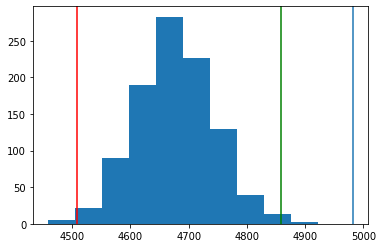

Remainder: 0.010000000000000009
lower: 4440.985
upper: 4791.035
total count: 4982
adding: 0



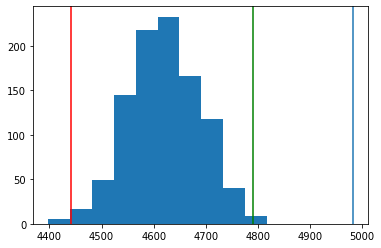

Remainder: 0.010000000000000009
lower: 4388.975
upper: 4737.0
total count: 4982
adding: 0



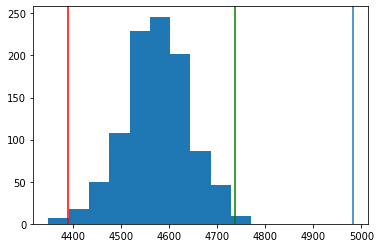

Remainder: 0.010000000000000009
lower: 4398.0
upper: 4735.01
total count: 4982
adding: 0



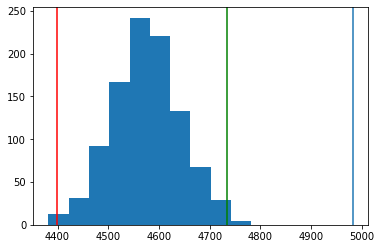

Remainder: 0.010000000000000009
lower: 4337.995
upper: 4698.0599999999995
total count: 4982
adding: 0



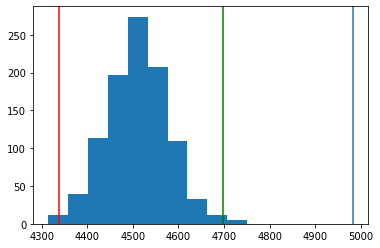

Remainder: 0.010000000000000009
lower: 4481.995
upper: 4823.02
total count: 4982
adding: 0



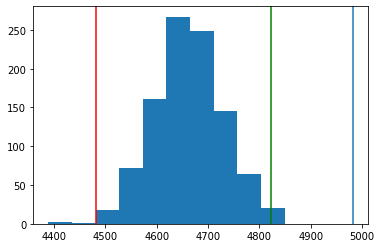

Remainder: 0.010000000000000009
lower: 4455.965
upper: 4797.015
total count: 4982
adding: 0



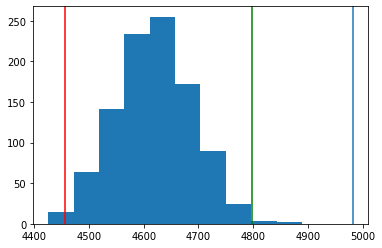

Remainder: 0.010000000000000009
lower: 4543.975
upper: 4878.01
total count: 4982
adding: 0



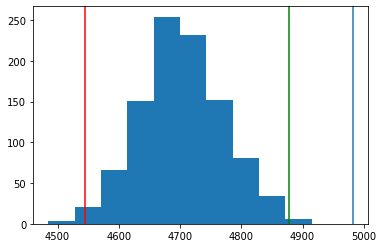

Remainder: 0.010000000000000009
lower: 4364.995000000001
upper: 4707.0199999999995
total count: 4982
adding: 0



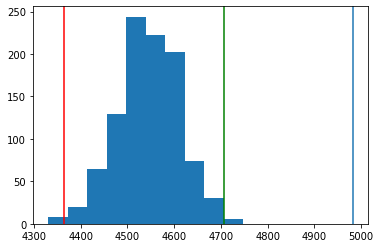

Remainder: 0.010000000000000009
lower: 4484.950000000001
upper: 4840.04
total count: 4982
adding: 0



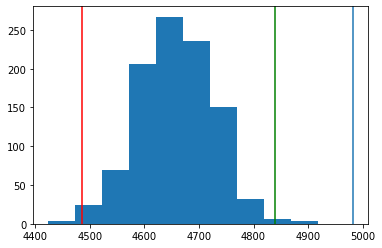

Remainder: 0.010000000000000009
lower: 4458.965
upper: 4813.01
total count: 4982
adding: 0



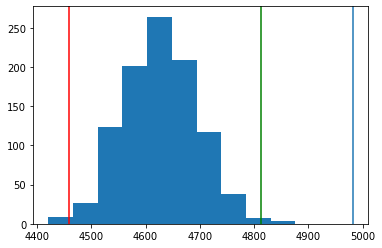

Remainder: 0.010000000000000009
lower: 4538.98
upper: 4886.015
total count: 4982
adding: 0



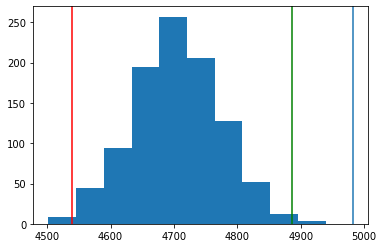

Remainder: 0.010000000000000009
lower: 4453.0
upper: 4792.0
total count: 4982
adding: 0



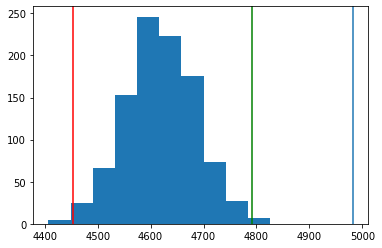

Remainder: 0.010000000000000009
lower: 4501.9400000000005
upper: 4846.01
total count: 4982
adding: 0



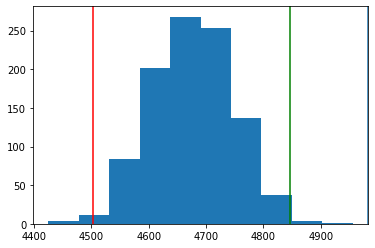

Remainder: 0.010000000000000009
lower: 4476.990000000001
upper: 4823.075
total count: 4982
adding: 0



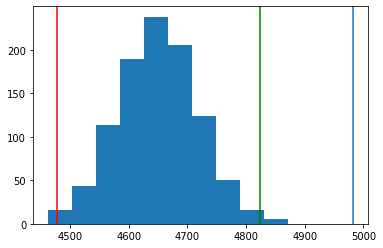

Remainder: 0.010000000000000009
lower: 4623.99
upper: 4975.025
total count: 4982
adding: 0



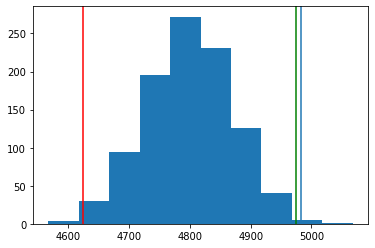

Remainder: 0.010000000000000009
lower: 4393.955
upper: 4721.03
total count: 4982
adding: 0



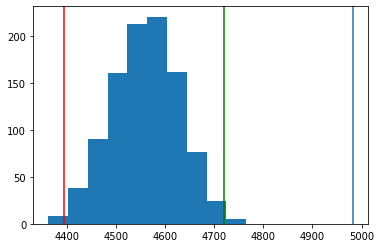

Remainder: 0.010000000000000009
lower: 4424.95
upper: 4774.035
total count: 4982
adding: 0



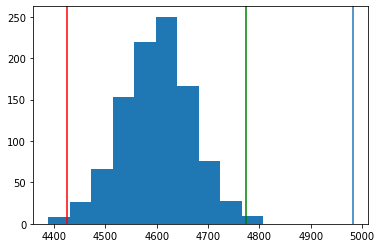

Remainder: 0.010000000000000009
lower: 4487.99
upper: 4846.08
total count: 4982
adding: 0



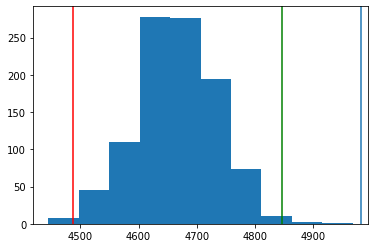

Remainder: 0.010000000000000009
lower: 4528.985
upper: 4878.005
total count: 4982
adding: 0



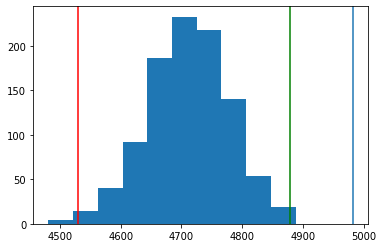

Remainder: 0.010000000000000009
lower: 4486.99
upper: 4830.030000000001
total count: 4982
adding: 0



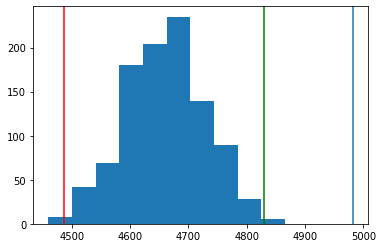

Remainder: 0.010000000000000009
lower: 4531.985
upper: 4869.015
total count: 4982
adding: 0



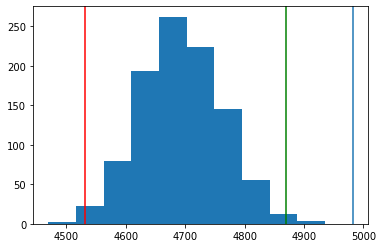

Remainder: 0.010000000000000009
lower: 4491.0
upper: 4823.045
total count: 4982
adding: 0



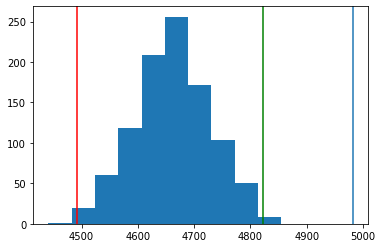

Remainder: 0.010000000000000009
lower: 4302.9800000000005
upper: 4628.035
total count: 4982
adding: 0



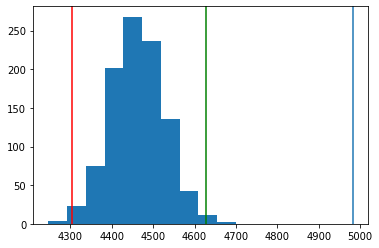

Remainder: 0.010000000000000009
lower: 4506.985
upper: 4852.025
total count: 4982
adding: 0



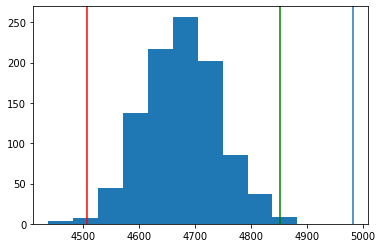

Remainder: 0.010000000000000009
lower: 4396.975
upper: 4739.0
total count: 4982
adding: 0



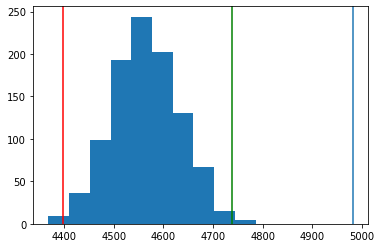

Remainder: 0.010000000000000009
lower: 4601.99
upper: 4927.015
total count: 4982
adding: 0



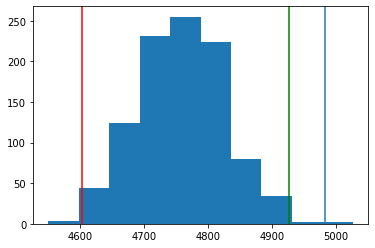

Remainder: 0.010000000000000009
lower: 4531.98
upper: 4905.11
total count: 4982
adding: 0



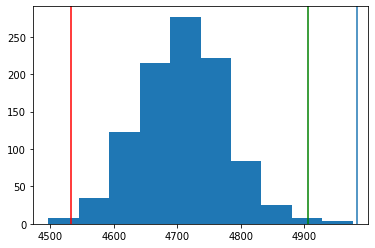

Remainder: 0.010000000000000009
lower: 4495.0
upper: 4842.01
total count: 4982
adding: 0



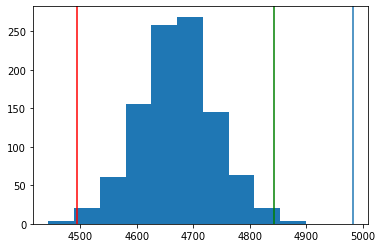

Remainder: 0.010000000000000009
lower: 4476.97
upper: 4847.025
total count: 4982
adding: 0



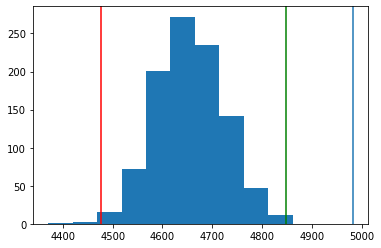

Remainder: 0.010000000000000009
lower: 4471.98
upper: 4801.055
total count: 4982
adding: 0



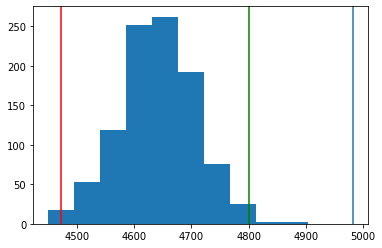

Remainder: 0.010000000000000009
lower: 4494.9800000000005
upper: 4850.0
total count: 4982
adding: 0



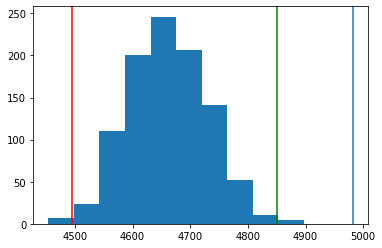

Remainder: 0.010000000000000009
lower: 4505.9349999999995
upper: 4884.025
total count: 4982
adding: 0



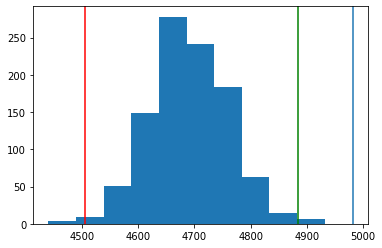

Remainder: 0.010000000000000009
lower: 4485.99
upper: 4836.0
total count: 4982
adding: 0



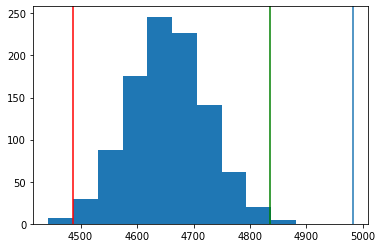

Remainder: 0.010000000000000009
lower: 4543.98
upper: 4897.005
total count: 4982
adding: 0



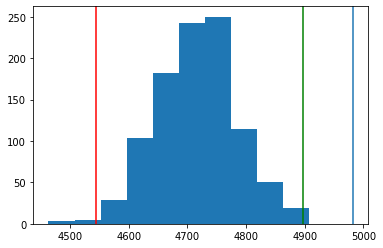

Remainder: 0.010000000000000009
lower: 4507.975
upper: 4837.05
total count: 4982
adding: 0



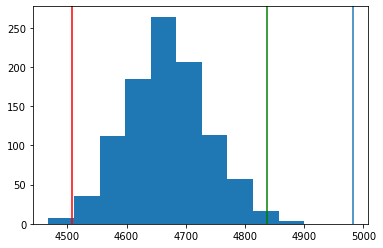

Remainder: 0.010000000000000009
lower: 4458.96
upper: 4829.005
total count: 4982
adding: 0



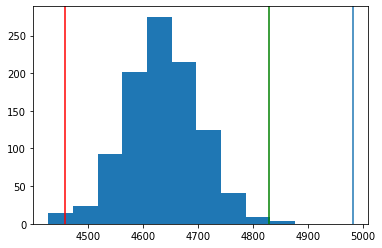

Remainder: 0.010000000000000009
lower: 4438.985000000001
upper: 4791.025
total count: 4982
adding: 0



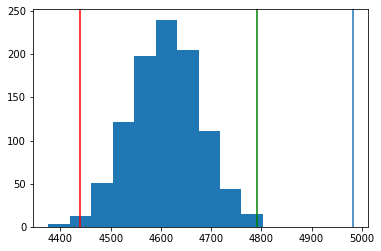

Remainder: 0.010000000000000009
lower: 4412.990000000001
upper: 4758.055
total count: 4982
adding: 0



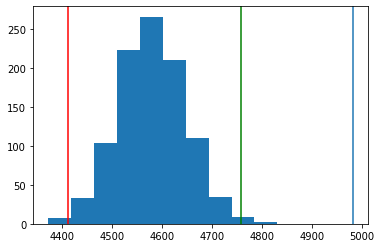

Remainder: 0.010000000000000009
lower: 4558.9800000000005
upper: 4901.06
total count: 4982
adding: 0



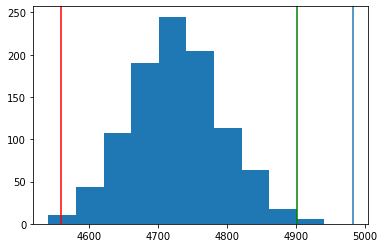

Remainder: 0.010000000000000009
lower: 4388.990000000001
upper: 4726.005
total count: 4982
adding: 0



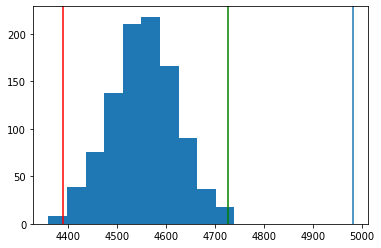

Remainder: 0.010000000000000009
lower: 4478.97
upper: 4810.005
total count: 4982
adding: 0



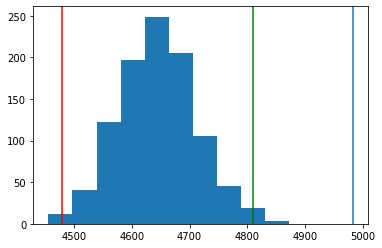

Remainder: 0.010000000000000009
lower: 4385.98
upper: 4735.025
total count: 4982
adding: 0



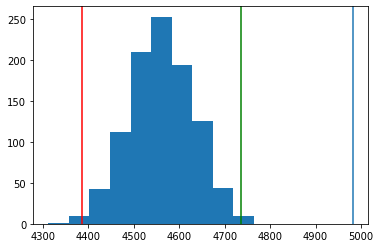

Remainder: 0.010000000000000009
lower: 4502.985000000001
upper: 4845.005
total count: 4982
adding: 0



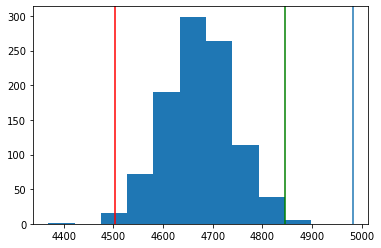

Remainder: 0.010000000000000009
lower: 4441.985
upper: 4781.005
total count: 4982
adding: 0



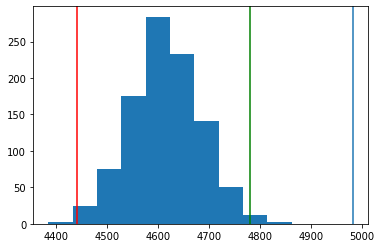

Remainder: 0.010000000000000009
lower: 4506.99
upper: 4840.015
total count: 4982
adding: 0



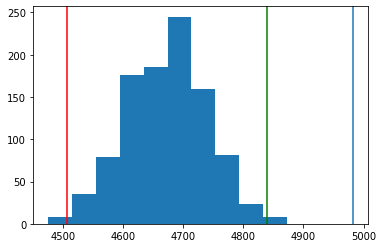

Remainder: 0.010000000000000009
lower: 4367.975
upper: 4674.014999999999
total count: 4982
adding: 0



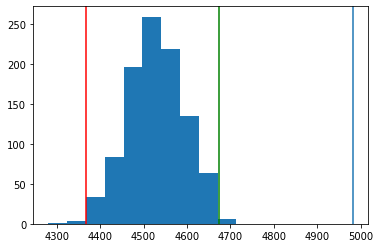

Remainder: 0.010000000000000009
lower: 4421.895
upper: 4772.0199999999995
total count: 4982
adding: 0



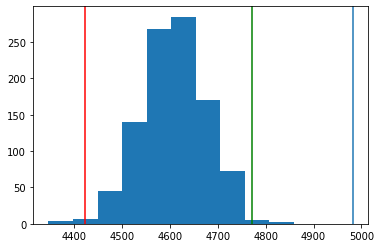

Remainder: 0.010000000000000009
lower: 4543.995
upper: 4890.0
total count: 4982
adding: 0



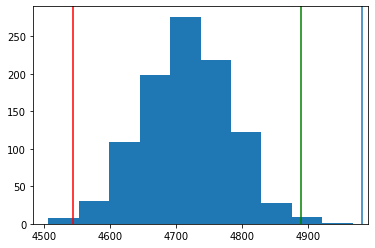

Remainder: 0.010000000000000009
lower: 4483.0
upper: 4804.025
total count: 4982
adding: 0



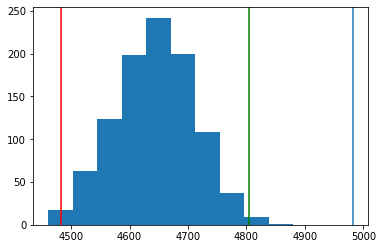

Remainder: 0.010000000000000009
lower: 4370.985
upper: 4717.055
total count: 4982
adding: 0



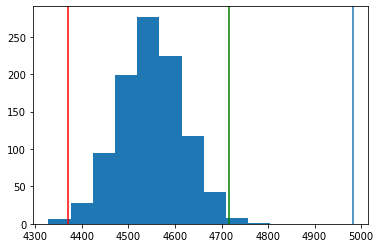

Remainder: 0.010000000000000009
lower: 4596.995000000001
upper: 4936.02
total count: 4982
adding: 0



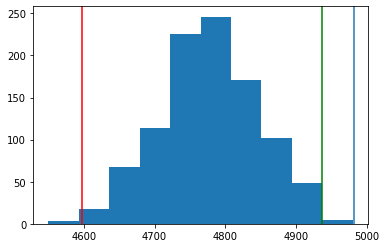

Remainder: 0.010000000000000009
lower: 4462.905000000001
upper: 4794.025
total count: 4982
adding: 0



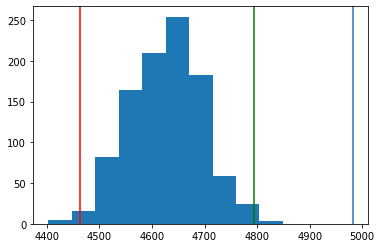

Remainder: 0.010000000000000009
lower: 4497.995
upper: 4850.005
total count: 4982
adding: 0



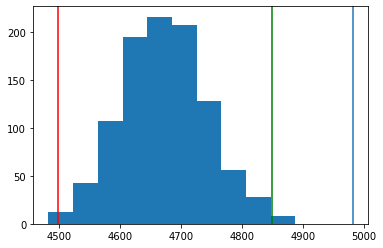

Remainder: 0.010000000000000009
lower: 4508.975
upper: 4873.005
total count: 4982
adding: 0



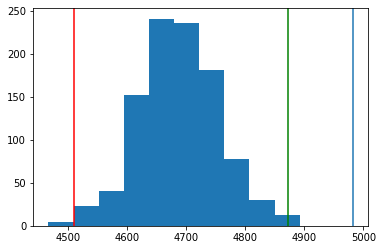

Remainder: 0.010000000000000009
lower: 4453.995
upper: 4794.08
total count: 4982
adding: 0



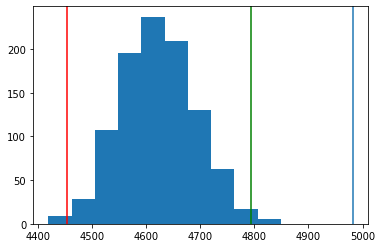

Remainder: 0.010000000000000009
lower: 4494.99
upper: 4838.005
total count: 4982
adding: 0



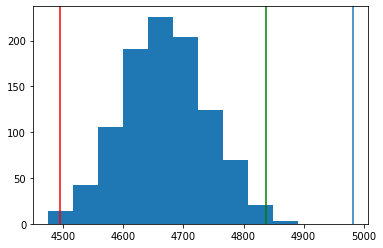

Remainder: 0.010000000000000009
lower: 4624.985
upper: 4980.009999999999
total count: 4982
adding: 0



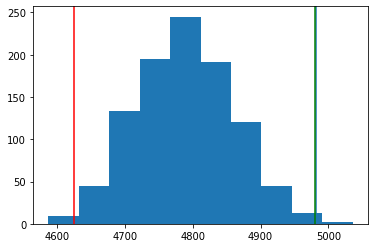

Remainder: 0.010000000000000009
lower: 4418.99
upper: 4780.055
total count: 4982
adding: 0



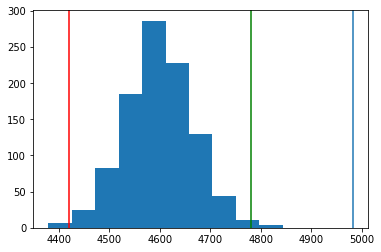

Remainder: 0.010000000000000009
lower: 4477.995
upper: 4790.005
total count: 4982
adding: 0



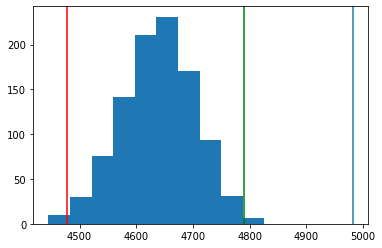

Remainder: 0.010000000000000009
lower: 4402.985
upper: 4741.01
total count: 4982
adding: 0



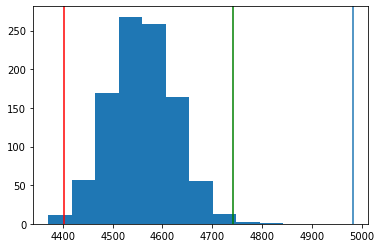

Remainder: 0.010000000000000009
lower: 4568.965
upper: 4904.035
total count: 4982
adding: 0



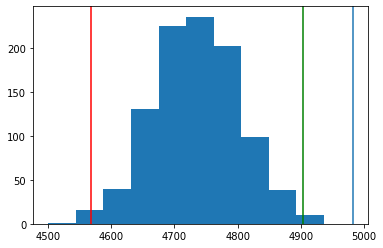

Remainder: 0.010000000000000009
lower: 4525.97
upper: 4862.05
total count: 4982
adding: 0



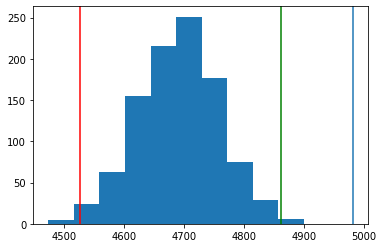

Remainder: 0.010000000000000009
lower: 4358.0
upper: 4746.01
total count: 4982
adding: 0



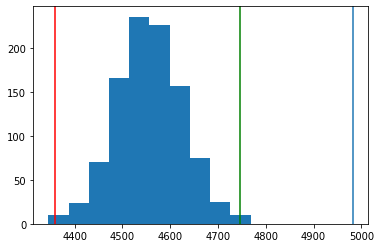

Remainder: 0.010000000000000009
lower: 4458.974999999999
upper: 4816.03
total count: 4982
adding: 0



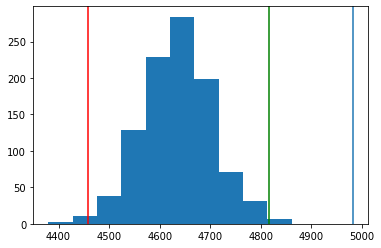

Remainder: 0.010000000000000009
lower: 4508.955
upper: 4878.02
total count: 4982
adding: 0



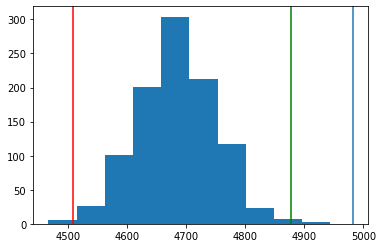

Remainder: 0.010000000000000009
lower: 4445.91
upper: 4792.025
total count: 4982
adding: 0



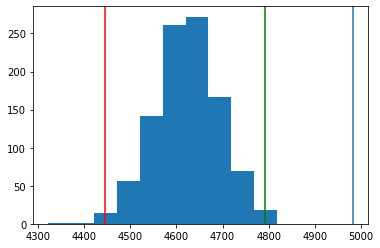

Remainder: 0.010000000000000009
lower: 4490.955
upper: 4826.005
total count: 4982
adding: 0



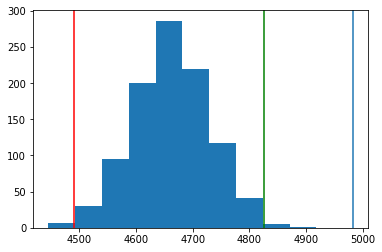

Remainder: 0.010000000000000009
lower: 4501.915
upper: 4826.045
total count: 4982
adding: 0



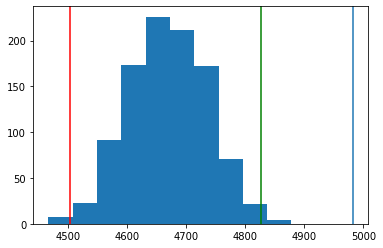

Remainder: 0.010000000000000009
lower: 4382.865
upper: 4708.0199999999995
total count: 4982
adding: 0



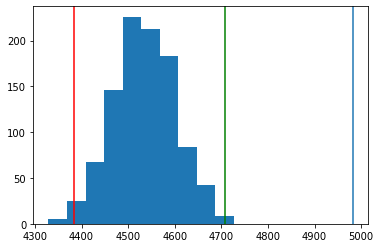

Remainder: 0.010000000000000009
lower: 4516.0
upper: 4868.0
total count: 4982
adding: 0



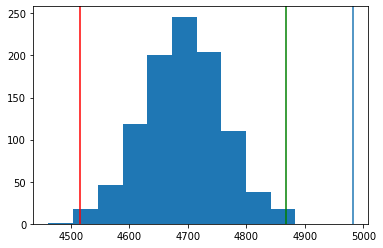

Remainder: 0.010000000000000009
lower: 4338.99
upper: 4691.004999999999
total count: 4982
adding: 0



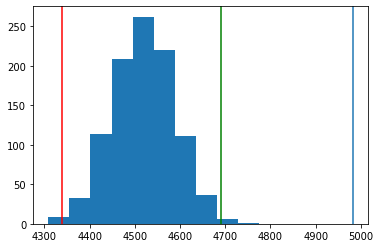

Remainder: 0.010000000000000009
lower: 4582.0
upper: 4928.045
total count: 4982
adding: 0



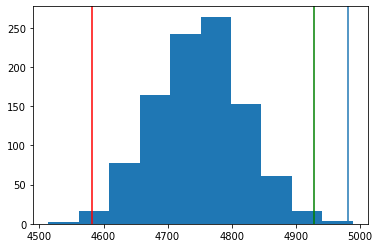

Remainder: 0.010000000000000009
lower: 4574.995
upper: 4921.0199999999995
total count: 4982
adding: 0



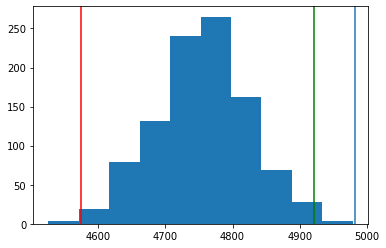

Remainder: 0.010000000000000009
lower: 4535.975
upper: 4903.005
total count: 4982
adding: 0



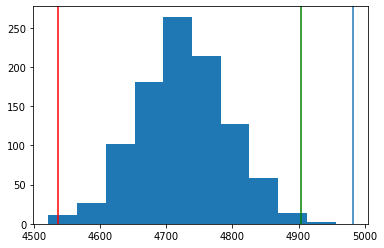

Remainder: 0.010000000000000009
lower: 4509.935
upper: 4869.015
total count: 4982
adding: 0



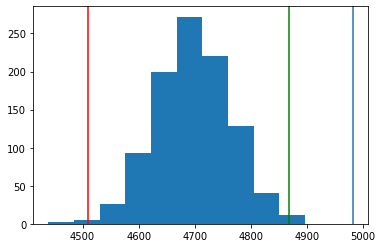

Remainder: 0.010000000000000009
lower: 4442.945
upper: 4792.02
total count: 4982
adding: 0



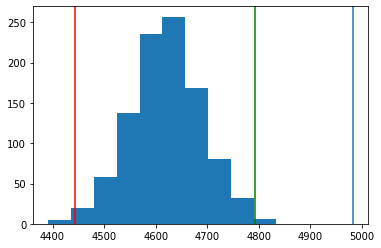

Remainder: 0.010000000000000009
lower: 4568.945
upper: 4930.045
total count: 4982
adding: 0



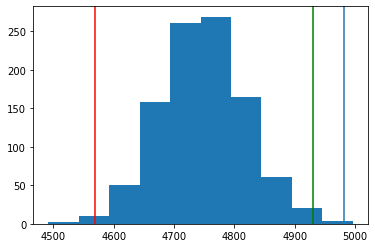

Remainder: 0.010000000000000009
lower: 4510.975
upper: 4830.08
total count: 4982
adding: 0



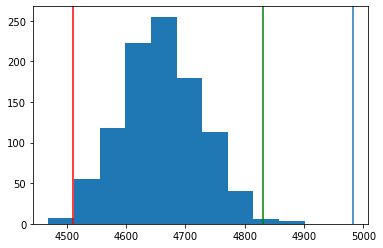

Remainder: 0.010000000000000009
lower: 4385.0
upper: 4750.045
total count: 4982
adding: 0



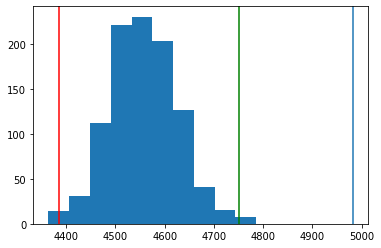

Remainder: 0.010000000000000009
lower: 4387.99
upper: 4729.055
total count: 4982
adding: 0



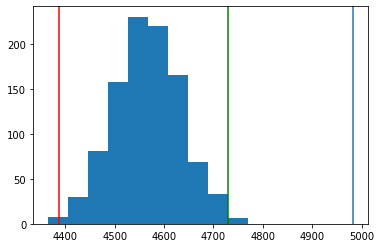

Remainder: 0.010000000000000009
lower: 4479.955
upper: 4831.0
total count: 4982
adding: 0



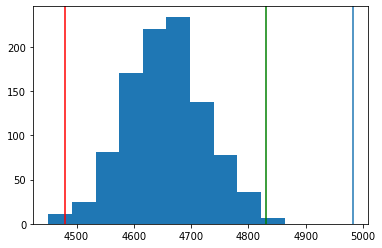

Remainder: 0.010000000000000009
lower: 4488.94
upper: 4830.01
total count: 4982
adding: 0



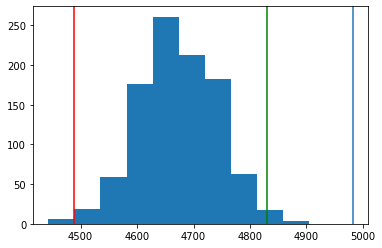

Remainder: 0.010000000000000009
lower: 4500.945000000001
upper: 4878.030000000001
total count: 4982
adding: 0



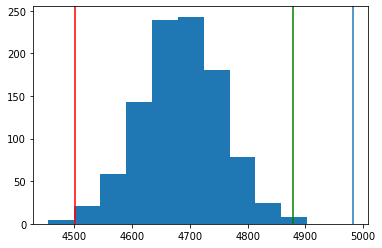

Remainder: 0.010000000000000009
lower: 4579.98
upper: 4940.025000000001
total count: 4982
adding: 0



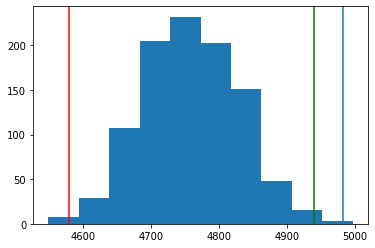

Remainder: 0.010000000000000009
lower: 4554.98
upper: 4914.01
total count: 4982
adding: 0



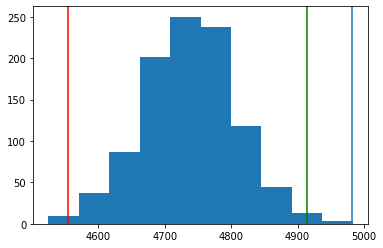

Remainder: 0.010000000000000009
lower: 4451.9349999999995
upper: 4783.055
total count: 4982
adding: 0



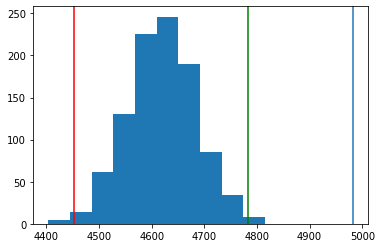

Remainder: 0.010000000000000009
lower: 4433.985
upper: 4749.045
total count: 4982
adding: 0



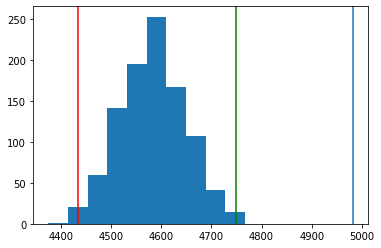

Remainder: 0.010000000000000009
lower: 4439.955
upper: 4775.0
total count: 4982
adding: 0



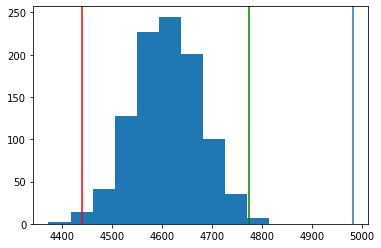

Remainder: 0.010000000000000009
lower: 4404.995000000001
upper: 4729.014999999999
total count: 4982
adding: 0



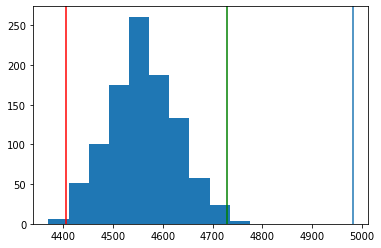

Remainder: 0.010000000000000009
lower: 4395.965
upper: 4732.005
total count: 4982
adding: 0



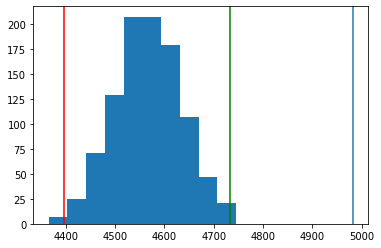

Remainder: 0.010000000000000009
lower: 4474.99
upper: 4825.0
total count: 4982
adding: 0



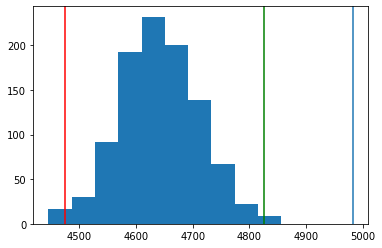

Remainder: 0.010000000000000009
lower: 4405.9400000000005
upper: 4743.005
total count: 4982
adding: 0



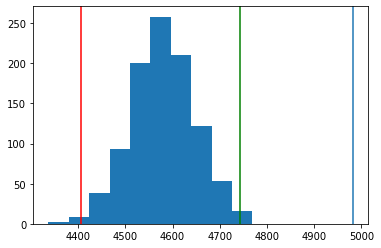

Remainder: 0.010000000000000009
lower: 4649.0
upper: 4997.0
total count: 4982
adding: 1



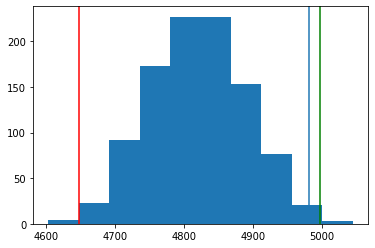

Remainder: 0.010000000000000009
lower: 4386.99
upper: 4720.025
total count: 4982
adding: 0



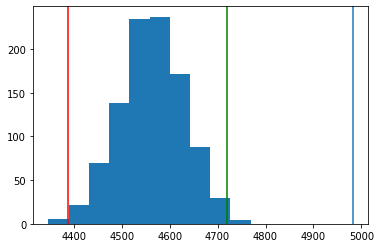

Remainder: 0.010000000000000009
lower: 4482.99
upper: 4826.049999999999
total count: 4982
adding: 0



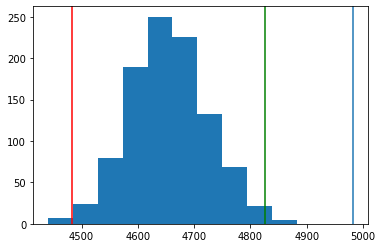

Remainder: 0.010000000000000009
lower: 4516.965
upper: 4877.005
total count: 4982
adding: 0



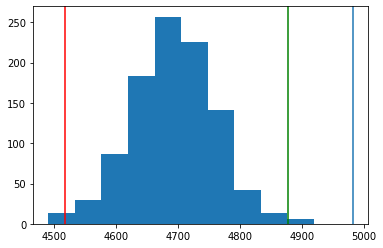

Remainder: 0.010000000000000009
lower: 4433.965
upper: 4788.0
total count: 4982
adding: 0



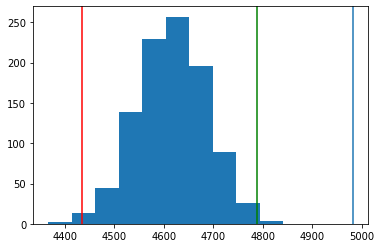

Remainder: 0.010000000000000009
lower: 4497.0
upper: 4865.014999999999
total count: 4982
adding: 0



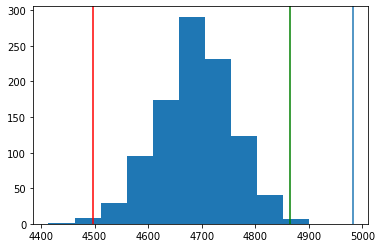

Remainder: 0.010000000000000009
lower: 4546.985
upper: 4885.005
total count: 4982
adding: 0



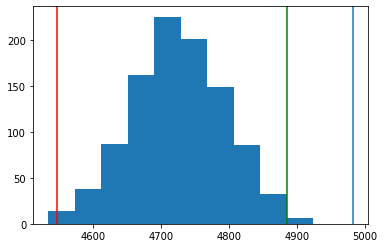

In [32]:
coverage = percentage_coverage(model, x_lockdown[:,0][:,np.newaxis], y_lockdown, num_pertubations=1000, num_samples=100, quantile=0.99, debug=True)
